# AAI614: Data Science & its Applications

*Notebook 8.4: Classifying Sentiments in Arabizi*

<a href="https://colab.research.google.com/github/harmanani/AAI614/blob/main/Week%208/Notebook8.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please check the following [paper](https://github.com/harmanani/AAI614/blob/main/Week%208/Arabizi.pdf) for reference purposes.

In [1]:
import io
import pandas as pd
import re
import csv
from random import shuffle
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import ssl
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, MaxPooling1D

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
ARABIZI_FILE = "2-class-sentiment-arabizi.csv"
# csvfile = pd.read_csv("https://raw.githubusercontent.com/harmanani/AAI614/refs/heads/main/Week%208/2-class-sentiment-arabizi.csv")
# ARABIZI_FILE=csvfile

As you can see, each data point is composed of a tweet, a sentiment label, and a highlight.  The highlight will not be used in this code.

## Defining useful global variables

Next you will define some global variables that will be used throughout the assignment.

- `NUM_WORDS`: The maximum number of words to keep, based on word frequency. Defaults to 2000.


- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.


- `MAXLEN`: Maximum length of all sequences. Defaults to 120.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "\<OOV>".

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.8

**For now leave them unchanged but after submitting your assignment for grading you are encouraged to come back here and play with these parameters to see the impact they have in the classification process**

In [3]:
NUM_WORDS = 2000
EMBEDDING_DIM = 64
PADDING = 'post'
OOV_TOKEN = '<OOV>'
TRAINING_SPLIT = 0.8
MAXLEN = 120

## Loading and pre-processing the data

Now you should code the functions to remove stopwords from text and to load the data from a csv file.

Since you already coded these functions for the previous week, these are provided for you.

In [4]:
def remove_stopwords(sentence):
    # List of stopwords
    stopwords = ['chu', 'chou', 'hal', 'chou', 'fikeee', 'eh', 'ma', '3a', '3am', '3an', '3ana', '3endon', '3m', 'aal', '3al','3ala','al', 'ana',
                 'b', 'bas', 'bel', 'bi', 'chi', 'el', 'ele', 'enn', 'enno', 'eno', 'mch', '3layki', '3layon',
                 'enta', 'enteh', 'eza', 'fi', 'fik', 'fina', 'fine', 'fiya', 'fiye', 'wlik', 'shi',
                 'hal', 'hayda', 'hek', 'inta', 'iza', 'kaza', 'kel', 'kente', 'kif',
                 'kint', 'kinte', 'l', 'la', 'la2na', 'lal', 'li', 'ma3', 'ma3a', 'ma3ak',
                 'ma3e', 'ma3ekk', 'ma3i', 'ma3ik', 'ma3ke', 'ma3na', 'ma3o', 'men', 'mn',
                 'n7na', 'shu', 'tab', 'tayeb', 'w', 'wlek', 'ya', 'ya3ne', 'yala', 'yalle']

    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

In [5]:
def clean_tweet(tweet):

    #if isinstance(tweet, float):
    #  return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = re.sub(r"h[ha]{3,}", "hahaha", temp)
    temp = re.sub(r"lo{1,}l", "lol", temp)
    return temp

<>:11: SyntaxWarning: invalid escape sequence '\['
<>:11: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-1934031976.py:11: SyntaxWarning: invalid escape sequence '\['
  temp = re.sub('\[.*?\]',' ', temp)


In [6]:
def parse_data_from_file(filename):
    sentences = []
    sentiments_labels = []
    emotions_labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            sentiments_labels.append(row[1])
            emotions_labels.append(row[2])
            sentence = row[0]
            sentence = remove_stopwords(sentence)
            sentence = clean_tweet(sentence)
            sentences.append(sentence)

    return sentences, sentiments_labels, emotions_labels

In [7]:
# Test the functions
sentences, sentiments_labels,  emotions_labels = parse_data_from_file(ARABIZI_FILE)

# Shuffle the lists
temp = list(zip(sentences, sentiments_labels, emotions_labels))
shuffle(temp)

res1, res2, res3 = zip(*temp)
sentences, sentiments_labels,  emotions_labels= list(res1), list(res2), list(res3)

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"First sentence has the following words: {sentences[0].split()}.\n")
print(f"There are {len(emotions_labels)} emotions labels in the dataset.")
print(f"The first 5 labels are {emotions_labels[:5]}\n")
print(f"There are {len(sentiments_labels)} sentiment labels in the dataset.\n")
print(f"The first 5 labels are {sentiments_labels[:5]}")

There are 1200 sentences in the dataset.

First sentence has 3 words (after removing stopwords).

First sentence has the following words: ['chaareh', 'ktir', 'astaze'].

There are 1200 emotions labels in the dataset.
The first 5 labels are ['None', 'Bullying', 'None', 'None', 'None']

There are 1200 sentiment labels in the dataset.

The first 5 labels are ['Positive', 'Negative', 'Positive', 'Positive', 'Positive']


## Training - Validation Split

`train_val_split`, which given the list of sentences, the list of labels and the proportion of data for the training set, returns the training and validation sentences and labels:

In [8]:
def train_val_split(sentences, labels, training_split):

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split) # YOUR CODE HERE

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [9]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, sentiments_labels, TRAINING_SPLIT)

# Test your function
vocab_size = len(train_sentences)
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
max_length = max([len(x) for x in sentences])
MAXLEN = max_length

print(f"The longest tweet is {max_length} characters long!\n")
print(f"There are {len(train_sentences)} sentences for training.")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.")
print(f"There are {len(val_labels)} labels for validation.")

The longest tweet is 256 characters long!

There are 960 sentences for training.
There are 960 labels for training.

There are 240 sentences for validation.
There are 240 labels for validation.


## Tokenization - Sequences and padding

Now that you have sets for training and validation it is time for you to begin the tokenization process.

Begin by completing the `fit_tokenizer` function below. This function should return a [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) that has been fitted to the training sentences.

In [10]:
def fit_tokenizer(train_sentences, num_words, oov_token):

    ### START CODE HERE

    vocab_size = len(train_sentences)
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    max_length = 120

    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_tok)

    # Fit the tokenizer to the training sentences

    # Generate the word index dictionary
    tokenizer.fit_on_texts(train_sentences)
    word_index = tokenizer.word_index


    ### END CODE HERE

    return tokenizer

In [11]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 3946 words

<OOV> token included in vocabulary


Now that the tokenizer has been fitted to the training data, you need a function that will convert each text data point into its padded sequence representation, for this complete the `seq_and_pad` function below:

In [12]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):

    ### START CODE HERE
    trunc_type='post'

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=trunc_type)

    ### END CODE HERE

    return padded_sequences

In [13]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (960, 256)

Padded validation sequences have shape: (240, 256)


Finally you need to tokenize the labels. For this complete the `tokenize_labels` function below.

A couple of things to note:
- You should fit the tokenizer to all the labels to avoid the case of a particular label not being present in the validation set. Since you are dealing with labels there should never be an OOV label.


- In the previous function you used the `pad_sequences` function which returns numpy arrays. Here you will not be using it since you don't need to pad the labels so you need to make the conversion to numpy arrays yourself.


- The argument `split_labels` refers to the labels of a particular split (train or validation). This is because the function should work independently of the split being used.


- Using Keras' Tokenizer yields values that start at 1 rather than at 0. This will present a problem when training since Keras usually expects the labels to start at 0. To work around this issue you could use an extra neuron in the last layer of your model. However this approach is rather hacky and not very clear. Instead you will substract 1 from every value of the labels that the function returns. Remember that when using numpy arrays you can simply do something like `np.array - 1` to accomplish this since numpy allows for vectorized operations.

In [14]:
def tokenize_labels(all_labels, split_labels):

    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()

    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)

    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq)-1

    return label_seq_np

In [15]:
train_label_seq = tokenize_labels(sentiments_labels, train_labels)
val_label_seq = tokenize_labels(sentiments_labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[0]
 [1]
 [0]
 [0]
 [0]]

First 5 labels of the validation set should look like this:
[[1]
 [0]
 [0]
 [1]
 [1]]

Tokenized labels of the training set have shape: (960, 1)

Tokenized labels of the validation set have shape: (240, 1)



## Selecting the model for text classification

Now that the data is ready to be fed a Neural Network it is time for you to define the model that will classify each text as being part of a certain category.

For this complete the `create_model` below.

A couple of things to keep in mind:

- Notice that this function has three parameters, all of which are meant to be passed to an [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer, which is what you will probably use as a first layer for your model.


- The last layer should be a Dense layer with 5 units (since there are 5 categories) with a softmax activation.


- You should also compile your model using an appropiate loss function and optimizer.


- You can use any architecture you want but keep in mind that this problem doesn't need many layers to be solved successfully. You don't need any layers beside Embedding, [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) and Dense layers but feel free to try out different architectures.

In [28]:
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

NUM_WORDS     = 6000
EMBEDDING_DIM = 200
BATCH_SIZE    = 256
NUM_EPOCHS    = 200
PATIENCE_ES   = 5


MODELS_DIR = Path("./models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [29]:
# Actual Model.  Can you replace this part? With what?

def create_model(num_words, embedding_dim, maxlen):

    #tf.random.set_seed(123)

    ### START CODE HERE

    lstm1_dim = 400
    lstm2_dim = 200
    lstm3_dim = 100
    dense1_dim = 400
    dense2_dim = 100

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words+1, embedding_dim, input_length=maxlen),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm3_dim)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(dense1_dim, activation='relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(300, activation='relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(dense2_dim, activation='relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model
def build_biLSTM(num_words, embedding_dim, maxlen):
    lstm1_dim = 400
    lstm3_dim = 100
    dense1_dim = 400
    dense2_dim = 100
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words+1, embedding_dim, input_length=maxlen),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm3_dim)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(dense1_dim, activation='relu'),
        tf.keras.layers.Dense(300, activation='relu'),
        tf.keras.layers.Dense(dense2_dim, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
def build_biGRU(num_words, embedding_dim, maxlen):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words+1, embedding_dim, input_length=maxlen),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(192, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [30]:
MODEL_BUILDERS = {
    "biLSTM":   lambda: build_biLSTM(NUM_WORDS, EMBEDDING_DIM, MAXLEN),
    "biGRU":    lambda: build_biGRU(NUM_WORDS, EMBEDDING_DIM, MAXLEN),
}

In [31]:

def make_callbacks(name):
    ckpt_path = MODELS_DIR / f"{name}.keras"
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE_ES, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=str(ckpt_path), monitor='val_accuracy',
                                           mode='max', save_best_only=True, save_weights_only=False)
    ]
    return callbacks
def train_one(name, model, X_tr, y_tr, X_val, y_val):
    history = model.fit(
        X_tr, y_tr,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=make_callbacks(name),
        verbose=1
    )
    # Best weights are already restored via EarlyStopping(restore_best_weights=True)
    # Still load checkpoint to be 100% aligned with best val_accuracy
    best_path = MODELS_DIR / f"{name}.keras"
    if best_path.exists():
        model = tf.keras.models.load_model(best_path)

    # Metrics on validation
    val_pred_prob = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0).ravel()
    val_pred = (val_pred_prob >= 0.5).astype(int)
    acc = accuracy_score(y_val, val_pred)
    f1  = f1_score(y_val, val_pred, average="macro")

    return model, history, {"val_accuracy": acc, "val_f1_macro": f1}
def train_all(models_dict, X_tr, y_tr, X_val, y_val):
    trained = {}
    histories = {}
    results = {}
    for name, builder in models_dict.items():
        print(f"\n===== Training {name} =====")
        model = builder()
        model.summary()
        model, hist, res = train_one(name, model, X_tr, y_tr, X_val, y_val)
        trained[name] = model
        histories[name] = hist
        results[name] = res
        print(f"--> {name} results:", res)
    return trained, histories, results

def plot_bar_results(results):
    names = list(results.keys())
    accs  = [results[n]["val_accuracy"] for n in names]
    f1s   = [results[n]["val_f1_macro"] for n in names]

    plt.figure(figsize=(8,5))
    x = np.arange(len(names))
    w = 0.35
    plt.bar(x - w/2, accs, width=w, label="Val Accuracy")
    plt.bar(x + w/2, f1s,  width=w, label="Val F1 (macro)")
    plt.xticks(x, names, rotation=15)
    plt.ylim(0, 1.0)
    plt.ylabel("Score")
    plt.title("Validation Accuracy & F1 (macro)")
    plt.legend()
    plt.grid(axis='y')
    plt.show()
def plot_histories(histories, metric="val_accuracy"):
    plt.figure(figsize=(8,5))
    for name, hist in histories.items():
        y = hist.history.get(metric, None)
        if y is not None:
            plt.plot(y, label=name)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"{metric} per epoch")
    plt.legend()
    plt.grid(True)
    plt.show()



In [32]:
trained_models, histories, results = train_all(
    MODEL_BUILDERS,
    train_padded_seq, train_label_seq,
    val_padded_seq,   val_label_seq
)


===== Training biLSTM =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 749ms/step - accuracy: 0.5238 - loss: 0.6931 - val_accuracy: 0.5208 - val_loss: 0.6927
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step - accuracy: 0.4935 - loss: 0.6937 - val_accuracy: 0.5625 - val_loss: 0.6940
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.5737 - loss: 0.6842 - val_accuracy: 0.5208 - val_loss: 0.6958
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - accuracy: 0.6522 - loss: 0.6449 - val_accuracy: 0.5500 - val_loss: 0.7122
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.7398 - loss: 0.5449 - val_accuracy: 0.6500 - val_loss: 0.6417
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 497ms/step - accuracy: 0.8198 - loss: 0.4176 - val_accuracy: 0.6250 - val_loss: 0.8199
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - accuracy: 0.8558 - loss: 0.3339 - val_accuracy: 0.6167 - val_loss: 0.7467
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.8826 - loss: 0.2834 - val_accuracy: 0.6625 - v

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.5158 - loss: 0.6935 - val_accuracy: 0.5625 - val_loss: 0.6902
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.5858 - loss: 0.6868 - val_accuracy: 0.5583 - val_loss: 0.6881
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.6568 - loss: 0.6649 - val_accuracy: 0.5417 - val_loss: 0.6833
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.7151 - loss: 0.5927 - val_accuracy: 0.6000 - val_loss: 0.7223
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.7890 - loss: 0.4500 - val_accuracy: 0.5625 - val_loss: 0.8996
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.8275 - loss: 0.3953 - val_accuracy: 0.6500 - val_loss: 0.7690
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.8741 - loss: 0.2889 - val_accuracy: 0.6125 - val_loss: 0.7760
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.9032 - loss: 0.2397 - val_accuracy: 0.6000 - v

Once training has finished you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.


=== Summary ===
{
  "biLSTM": {
    "val_accuracy": 0.6625,
    "val_f1_macro": 0.6551662971175166
  },
  "biGRU": {
    "val_accuracy": 0.65,
    "val_f1_macro": 0.6484375
  }
}


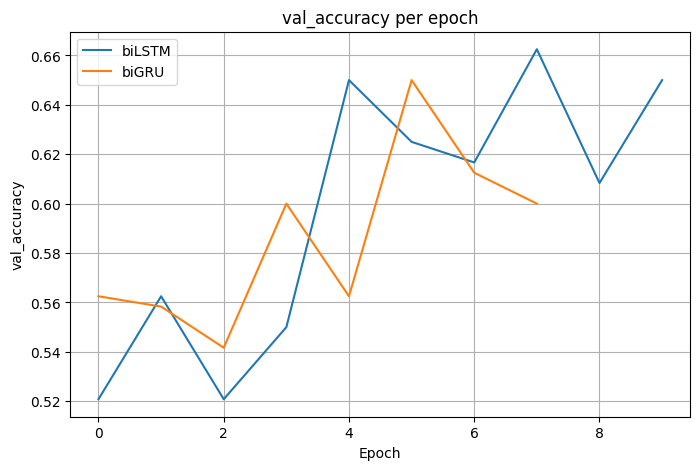

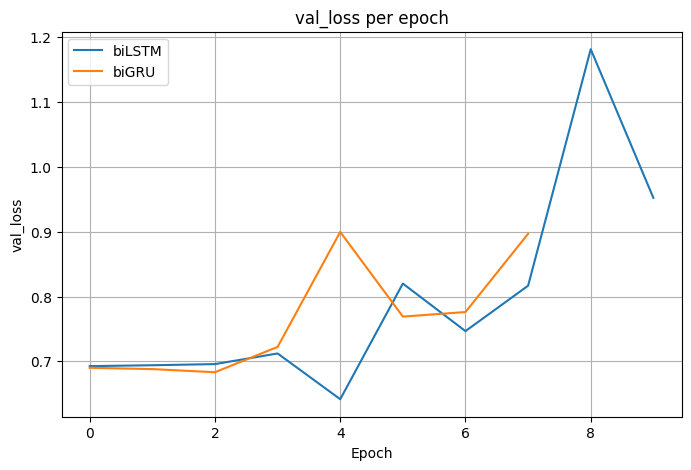

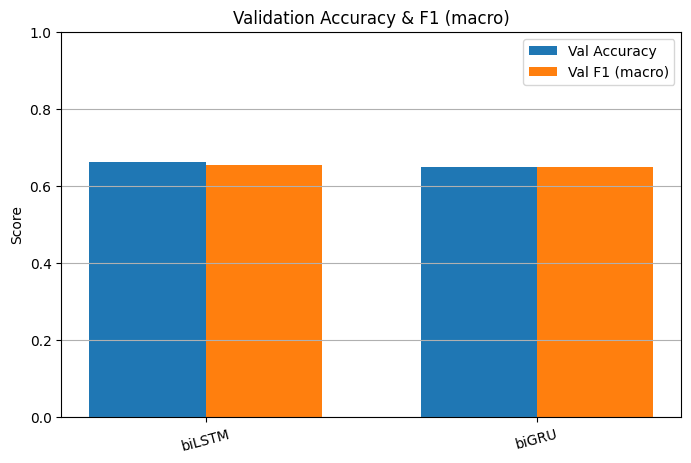

In [34]:
import json
print("\n=== Summary ===")
print(json.dumps(results, indent=2))

# Curves & bars
plot_histories(histories, metric="val_accuracy")
plot_histories(histories, metric="val_loss")
plot_bar_results(results)

## Visualizing 3D Vectors

We can visualize the vectors associated with each word in the training set in a 3D space.

For this run the following cells and visit [Tensorflow's Embedding Projector](https://projector.tensorflow.org/).

In [20]:
# Reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (6001, 200)


Now run the following cell to generate the `vecs.tsv` and `meta.tsv` files that you will upload to the embedding projector.